# Executive Summary
In this project, we are going to work with a dataset related to credit card fraud and we obtained this dataset from Kaggle. The transactions in this dataset are from European cardholders and made in September 2013. For financial service, any kind of fraud may cause significant damage not only to their profit and also their brand equity such as branding and reputation. Therefore it is extremely important for institution to have a trust worthy system to detect fraud of their products. Here we will use machine learning to help us detect whether the transaction is fraud or not using its attributes. Unfortunately, given the nature of privacy sensitive dataset, the dataset provider needs to keep orginal features confidential. Therefore majority of columns/features will be product from PCA (Principle Component Analysis). 
<br>
<br>Hence, our main objective in this dataset is to practice skills like how to deal with imbalance dataset, building machine learning models and metric selection. From our evaluation, we would recommend using Over-Sampling method and XGBoost classifier given it has the highest AUC score.

In [1]:
#Before starting, we import all the necessary package
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
%matplotlib inline

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, neural_network
from sklearn.metrics import precision_score, auc, roc_curve
import xgboost as xgb

# Exploratory Data Analysis (EDA)

First, we obtain the Credit Card Fraud Detection dataset from Kaggle (https://www.kaggle.com/dalpozz/creditcardfraud), and we will explore what this dataset is like.

#### Data Description
<li> Time - the seconds elapsed between each transaction and the first transaction in the dataset
<li> V1 to V28 - principle components of the transaction, where each is an attribute of the person or an attribute of the transaction itself
<li> Amount - the dollar amount of the transaction
<li> Class - whether it is a fraud or not, 1 if it is a fraud, otherwise 0

In [2]:
df = pd.read_csv("creditcard.csv")

In [3]:
#first 5 rows of the dataset
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
#there are 284807 rows and 31 columns
df.shape

(284807, 31)

In [5]:
#snapshot of each column data structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [6]:
#there is no NAs
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [7]:
#there is 492 cases of fraud transaction
(df.Class==1).sum()

492

In [8]:
#there are 284215 cases of normal transaction
(df.Class==0).sum()

284315

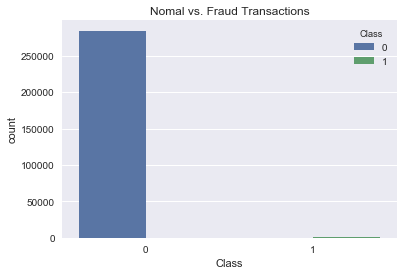

In [9]:
#we create a plot to visualize the imbalance
a = sns.countplot(x="Class", hue="Class", data=df)
a.set_title("Nomal vs. Fraud Transactions")
plt.show()

As we have seen above, the dataset is very imbalance where fraud transaction is only 0.17%(492 cases) of our total dataset. This would make our machine learning model meaningless if we just feed this imbalance dataset to it. For example, if we have an accuracy score of 90% correct, it doesn't mean our model is very "accurate" because there are more than 90% of data are normal transactions and our model just couldn't capture the significant identifications out of the 0.17% fraud transaction and identify them. 
<br>
<br>Therefore we have to explore solution for this. One could be collect more data, so we will have a more balance dataset between the two classes. But this could be more time, more resources and it would be costly. Another way is to perform Resampling, where we use a package to process the data and have a ratio of 50/50 between the two classes. Here we will use Over-sampling where we add more data of the less amount class, in the case is fraud transanctions, to the dataset. We will do this in the Data Cleaning section.

Our final part of EDA would be to take a look of all those PCA features, V1-V28. The purpose of PCA is to allow you determine which feature best capture the importance of the transaction and use those for building less costly machine learning models. But for this project, we want to see which feature(s) could best capture the difference of two classes that we want to identify. In order word, we want to see which feature is significant enought to help us identify whether it is a fraud or not. So we will plot distribution of each features between two classes. If they are not very similiar distributions, that means they are good identifications.

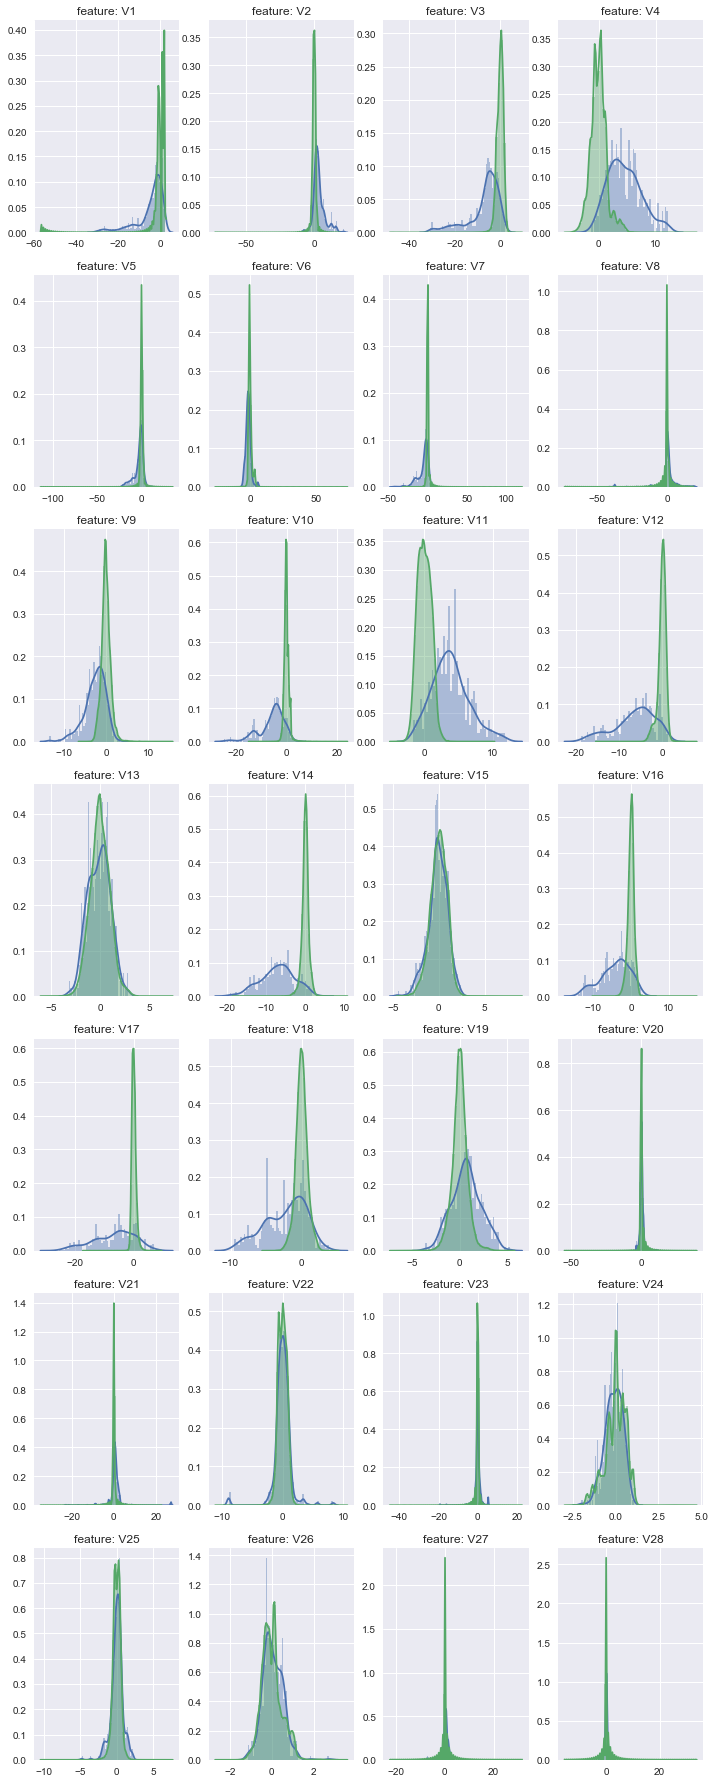

In [10]:
plt.figure(figsize=(12,8*4))
gs = gridspec.GridSpec(7, 4)
for i, cn in enumerate(df[df.iloc[:, 1:29].columns]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50)
    sns.distplot(df[cn][df.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(cn))
plt.show()

# Cleaning

After EDA, we know that there are a few things we need to do before we pass the data to build machine learning models.
<li> drop features that not significant enough to help us seperate/identify two classes
<li> use Over-sampling to resample our data to a balance dataset

In [11]:
#we create a list of features that not significant enough to help us idenify
FeaturesToDrop = ["V28", "V27", "V26", "V25", "V24", "V23", "V22", "V20", "V15", "V13", "V8"]

In [12]:
#drop those features
df = df.drop(FeaturesToDrop, axis=1)

In [13]:
#when we deal with dollar feature, we need to normalize them, 
#so that we could have a better distributed data for comparision
df["NormalizedAmount"] = StandardScaler().fit_transform(df["Amount"].reshape(-1,1))

/Users/ka/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()


In [14]:
#drop the original Amount column
#drop the Time column because it is not useful
df = df.drop(["Amount", "Time"], axis=1)

In [15]:
#these will be the columns we use for machine learning
df.columns.values

array(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11',
       'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'Class',
       'NormalizedAmount'], dtype=object)

In [16]:
#Resample using Over-sampling
X = df.drop("Class", axis=1)
y = df.Class
X_resample, y_resample = SMOTE().fit_sample(X, y)

In [17]:
#amount of x variables data after resampling
len(X_resample)

568630

In [18]:
#amount of y variable data after resampling
len(y_resample)

568630

In [19]:
#number of normal transaction after resampling
(y_resample==0).sum()

284315

In [20]:
#number of fraud transaction after resampling
(y_resample==1).sum()

284315

# Maching Learning

Now we have a balance dataset and features that could help us idenify the two classes, we will split the dataset to 80/20 ratio and build some machine learning models for fun!

In [21]:
#Splitting
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, 
                                                    test_size=0.2
                                                   ,random_state=3)

In [22]:
#list of machine learning models that we use
clfs = [
   linear_model.LogisticRegressionCV(),
   naive_bayes.GaussianNB(),
   tree.DecisionTreeClassifier(max_depth=5),
   ensemble.RandomForestClassifier(max_depth=5, n_estimators=10),
   discriminant_analysis.QuadraticDiscriminantAnalysis(),
   discriminant_analysis.LinearDiscriminantAnalysis(),
   neural_network.MLPClassifier()
]

In [23]:
#train, test and print out the Precision Score and AUC of each machine learning models
CLF_columns = []
CLF_compare = pd.DataFrame(columns = CLF_columns)

row_index = 0
for clf in clfs:
   y_pred = clf.fit(X_train, y_train).predict(X_test)
   fp, tp, th = roc_curve(y_test, y_pred)
   CLF_name = clf.__class__.__name__
   CLF_compare.loc[row_index,'CLF Name'] = CLF_name
   CLF_compare.loc[row_index, 'Precision'] = precision_score(y_test, y_pred)
   CLF_compare.loc[row_index, 'AUC'] = auc(fp, tp)
   
   row_index+=1
CLF_compare.sort_values(by = ['AUC'], ascending = False, inplace = True)
CLF_compare

,CLF Name,Precision,AUC
6,MLPClassifier,0.998879,0.999392
2,DecisionTreeClassifier,0.956552,0.951460
3,RandomForestClassifier,0.992297,0.945957
0,LogisticRegressionCV,0.972040,0.937449
4,QuadraticDiscriminantAnalysis,0.965368,0.924957
1,GaussianNB,0.979478,0.917405
5,LinearDiscriminantAnalysis,0.986511,0.914812


In [24]:
#create a DMatrix for XGBoost requirment
#preform 500 rounds and stop if we couldn't get a better score after 20 rounds
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
clf = xgb.XGBClassifier(n_estimators=500, 
                        objective="binary:logistic", 
                        eval_metric="auc", 
                        eta=0.1, 
                        max_depth=6, 
                        subsample=1, 
                        colsample_bytree=0.3, 
                        silent=1)
clf.fit(X_train, y_train, 
        early_stopping_rounds=20, 
        eval_metric="auc", 
        eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.979028
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.983157
[2]	validation_0-auc:0.986788
[3]	validation_0-auc:0.98926
[4]	validation_0-auc:0.98991
[5]	validation_0-auc:0.990939
[6]	validation_0-auc:0.991486
[7]	validation_0-auc:0.991985
[8]	validation_0-auc:0.993548
[9]	validation_0-auc:0.994492
[10]	validation_0-auc:0.99449
[11]	validation_0-auc:0.994778
[12]	validation_0-auc:0.99516
[13]	validation_0-auc:0.995479
[14]	validation_0-auc:0.995589
[15]	validation_0-auc:0.995743
[16]	validation_0-auc:0.996
[17]	validation_0-auc:0.996136
[18]	validation_0-auc:0.996413
[19]	validation_0-auc:0.996655
[20]	validation_0-auc:0.99673
[21]	validation_0-auc:0.996887
[22]	validation_0-auc:0.996979
[23]	validation_0-auc:0.997089
[24]	validation_0-auc:0.997178
[25]	validation_0-auc:0.997286
[26]	validation_0-auc:0.997445
[27]	validation_0-auc:0.997569
[28]	validation_0-auc:0.997748
[29]	validation_0-auc:0.997805
[30]	validation_0-auc:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, eta=0.1, eval_metric='auc', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=1)

From above 8 machine learning models and preformance, we could see that XGBoost has the best AUC and we think XGBoost wins!